# The Canada/US Border Crossing Dataset


*Exploration of whether the variance in border crossings since 1972 is related to socio-economic indices*

## Load Data

**Import Libraries**

In [2]:
import pandas as pd #working with dataframes

**Load Data**

In [3]:
# Data accessed from: https://open.canada.ca/data/en/dataset/6e438d59-880a-4f5e-827d-6c35243cf10a
# Data accessed on: 2019-05-24

border_df_000 = pd.read_csv('24100002.csv')

C:\DataScience\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Dataset Versions**

* 000 - raw dataset
* 001 - reduce column 'Length of stay' to a single class 'Length of stay, total'
* 002 - remove columns with 1 or less unique elements/classes
* 003 - remove DGUID column (NaNs); replace with Region column based on GEO
* 004 - reduce 'Mode of transportation' to a single class 'Total'; remove 'Total' from 'Trip characteristics'
* 005 - remove 'Canada' entries from 'Region' column

## Data Exploration

In [73]:
border_df_000.head()

,REF_DATE,GEO,DGUID,Trip characteristics,Length of stay,Mode of transportation,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1972-01,Canada,2016A000011124,Total vehicles entering Canada,"Length of stay, total","Mode of transportation, total",Number,223,units,0,v129299,1.1.1.1,1427026.0,NaN,NaN,NaN,0
1,1972-01,Canada,2016A000011124,Total United States vehicles entering,"Length of stay, total","Mode of transportation, total",Number,223,units,0,v129300,1.2.1.1,616944.0,NaN,NaN,NaN,0
2,1972-01,Canada,2016A000011124,Total United States vehicles entering,"Length of stay, total",Automobiles,Number,223,units,0,v129301,1.2.1.2,557108.0,NaN,NaN,NaN,0
3,1972-01,Canada,2016A000011124,Total United States vehicles entering,"Length of stay, total",Trucks,Number,223,units,0,v129305,1.2.1.3,59491.0,NaN,NaN,NaN,0
4,1972-01,Canada,2016A000011124,Total United States vehicles entering,"Length of stay, total",Other vehicles,Number,223,units,0,v129306,1.2.1.4,345.0,NaN,NaN,NaN,0


In [74]:
border_df_000.shape

(769590, 17)

### What are the number of NaNs for each column?

In [75]:
border_df_000.isna().sum()

REF_DATE                       0
GEO                            0
DGUID                     684540
Trip characteristics           0
Length of stay                 0
Mode of transportation         0
UOM                            0
UOM_ID                         0
SCALAR_FACTOR                  0
SCALAR_ID                      0
VECTOR                         0
COORDINATE                     0
VALUE                       3960
STATUS                    765630
SYMBOL                    769590
TERMINATED                769590
DECIMALS                       0
dtype: int64

*Several features are almost completely NaNs. 0.5% of the target (i.e., 'Value') are NaNs*

### What are the number of unique elements for each column?

In [76]:
border_df_000.nunique()

REF_DATE                    567
GEO                         142
DGUID                        10
Trip characteristics          3
Length of stay                4
Mode of transportation        4
UOM                           1
UOM_ID                        1
SCALAR_FACTOR                 1
SCALAR_ID                     1
VECTOR                     2130
COORDINATE                 4260
VALUE                     78833
STATUS                        1
SYMBOL                        0
TERMINATED                    0
DECIMALS                      1
dtype: int64

*Any feature that has 1 or less unique elements can be removed, since there is no variance to explore*

### Look at the distribution of crossings

Lets create a barchart comparing the number of crossings for Canada and each Province/Territory and subdivide by citizenship

In [30]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

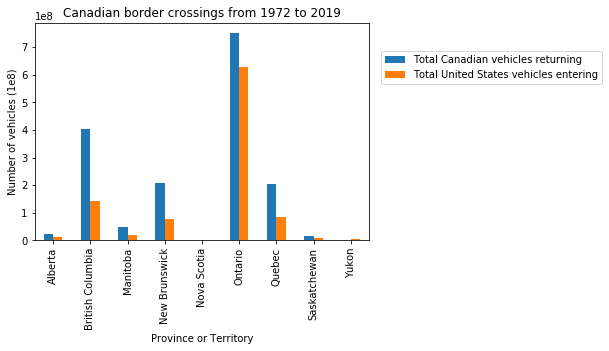

In [83]:
# Bar chart of crossings by Province/Territory

# Let's remove the total Canadian crossings for every year
border_df_005 = border_df_004[border_df_004['Region'] != 'Canada']

# source code for .unstack() : https://stackoverflow.com/questions/48238305/bar-plot-with-groupby
# we group the data by Province/Territory and then by citizenship and return the sum of value
border_df_005.groupby(['Region','Trip characteristics'])['VALUE'].sum().unstack().plot(kind = 'bar')

plt.title('Canadian border crossings from 1972 to 2019')
plt.ylabel('Number of vehicles (1e8)')
plt.xlabel('Province or Territory')

plt.legend(bbox_to_anchor=(1.45, 0.8),
           bbox_transform=plt.gcf().transFigure)

*Ontario has had 2x more crossings than any other province or territory. Unlike the others, the number of US vehicles crossing is much closer to the number of Canadian vehicles returning. The Yukon is the only region to have a greater number of US vehicles entering than Canadian vehicles returning.*

## Data Munging

**Reduce 'Length of Stay' to a single class 'Total'**

In [77]:
# For this study we are not interested in the 'Length of stay'
border_df_001 = border_df_000[border_df_000['Length of stay'] == 'Length of stay, total']
print(border_df_000.shape)
print(border_df_001.shape)

(769590, 17)
(461754, 17)


*This reduced the number of rows by 40%*

**Drop columns that have 1 or less unique elements**

In [78]:
drop_nonunique = [] # create an empty list to put columns to be dropped in
column_unique = border_df_001.nunique() # shows the number of unique elements in each feature

for i in range(len(border_df_001.nunique())):
    if column_unique[i] <= 1: # if the number of unique elements in each feature is <= 1
        drop_nonunique.append(column_unique.index[i]) # add that column to the list

drop_nonunique    

['Length of stay',
 'UOM',
 'UOM_ID',
 'SCALAR_FACTOR',
 'SCALAR_ID',
 'STATUS',
 'SYMBOL',
 'TERMINATED',
 'DECIMALS']

In [79]:
border_df_002 = border_df_001.drop(drop_nonunique, axis = 1)
print(border_df_000.shape)
print(border_df_002.shape)

(769590, 17)
(461754, 8)


*This reduced the number of columns by 53%*

**Create a Region Column Based on GEO. Remove DGUID**

In [80]:
#Create a list of all border crossing sites
GEO_list = border_df_002['GEO'].unique().tolist()

#Create an empty dictionary to populate
Region_key = {}

# For each site listed in 'GEO' associate the province
# For cities, split on the comma and add the province
# For provinces, just duplicate the value
for i in GEO_list:
    comma_position = i.find(',')
    if comma_position != -1:
        region_split = i.split(',')
        region_value = region_split[1].strip()
    else:
        region_value = i
        
    Region_key[i] = region_value

# Drop DGUID column
border_df_003 = border_df_002.drop('DGUID', axis = 1)

# Add a column for Region
border_df_003['Region'] = border_df_003['GEO'].map(Region_key)
border_df_003.head()

,REF_DATE,GEO,Trip characteristics,Mode of transportation,VECTOR,COORDINATE,VALUE,Region
0,1972-01,Canada,Total vehicles entering Canada,"Mode of transportation, total",v129299,1.1.1.1,1427026.0,Canada
1,1972-01,Canada,Total United States vehicles entering,"Mode of transportation, total",v129300,1.2.1.1,616944.0,Canada
2,1972-01,Canada,Total United States vehicles entering,Automobiles,v129301,1.2.1.2,557108.0,Canada
3,1972-01,Canada,Total United States vehicles entering,Trucks,v129305,1.2.1.3,59491.0,Canada
4,1972-01,Canada,Total United States vehicles entering,Other vehicles,v129306,1.2.1.4,345.0,Canada


**Reduce 'Mode of transportation' to a single class 'Total'**

In [82]:
# Reduce 'Mode of transportation' to a single class
border_df_004 = border_df_003[border_df_003['Mode of transportation'] == 'Mode of transportation, total']
border_df_004 = border_df_004.drop(['Mode of transportation'], axis = 1)

# Remove total for 'Trip characteristics'
border_df_004 = border_df_004[border_df_004['Trip characteristics'] != 'Total vehicles entering Canada']
print(border_df_000.shape)
print(border_df_004.shape)

(769590, 17)
(102612, 7)
